## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Load Data

In [2]:
pd.set_option('display.max_columns', None)

df = pd.read_csv('EDA_cleaned.csv')
df.head()

,Created,DepartureTime,TicketID,ReserveStatus,Male,Price,CouponDiscount,From,To,Domestic,TripReason,Vehicle,Cancel,PriceGroup,CouponDiscountGroup
0,2022-10-23 09:38:49.110,2022-11-02 23:59:00,1091777.0,5,1,6600000.0,34425.0,گرگان,تهران,1,Work,Plane,0,40000+,30000-35000
1,2022-08-15 14:51:43.160,2022-08-18 04:15:00,1070902.0,5,1,9500000.0,0.0,مشهد,تهران,1,Int,Plane,0,40000+,<20000
2,2022-09-20 17:25:27.250,2022-09-21 11:00:00,7624237.0,3,0,2000000.0,0.0,شیراز,اهواز,1,Work,Bus,0,40000+,<20000
3,2022-06-25 11:32:53.980,2022-06-26 08:30:00,2867547.0,2,0,40000.0,0.0,تبریز,جلفا,1,Int,Train,0,35000-40000,<20000
4,2022-06-01 11:30:53.633,2022-06-02 23:00:00,7212559.0,3,1,1130000.0,0.0,تهران,نجف آباد (اصفهان ),1,Int,Bus,0,40000+,<20000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101013 entries, 0 to 101012
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Created              101013 non-null  object 
 1   DepartureTime        101013 non-null  object 
 2   TicketID             101013 non-null  float64
 3   ReserveStatus        101013 non-null  int64  
 4   Male                 101013 non-null  int64  
 5   Price                101013 non-null  float64
 6   CouponDiscount       101013 non-null  float64
 7   From                 101013 non-null  object 
 8   To                   101013 non-null  object 
 9   Domestic             101013 non-null  int64  
 10  TripReason           101013 non-null  object 
 11  Vehicle              101013 non-null  object 
 12  Cancel               101013 non-null  int64  
 13  PriceGroup           101013 non-null  object 
 14  CouponDiscountGroup  101013 non-null  object 
dtypes: float64(3), in

In [4]:
# Konversi datetime di awal
df['Created'] = pd.to_datetime(df['Created'])
df['DepartureTime'] = pd.to_datetime(df['DepartureTime'])

In [5]:
#fix category orders
price_order = ['<20000', '20000-25000', '25000-30000', '30000-35000', '35000-40000', '40000+']


df['PriceGroup'] = pd.Categorical(df['PriceGroup'], categories=price_order, ordered=True)


Discount_order = ['<20000', '20000-25000', '25000-30000', '30000-35000', '35000-40000', '40000+']

df['CouponDiscountGroup'] = pd.Categorical(df['CouponDiscountGroup'], categories=Discount_order, ordered=True)



In [6]:
# Pilih kolom numerik
numeric_cols = df.select_dtypes(include=['number']).columns
numeric_cols

Index(['TicketID', 'ReserveStatus', 'Male', 'Price', 'CouponDiscount',
       'Domestic', 'Cancel'],
      dtype='object')

In [7]:
import scipy.stats as stats

def check_plot(df, variable):
    # fungsi mengambil kerangka data (df) dan
    # variabel yang diminati sebagai argumen

    # tentukan ukuran gambar
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # plot Q-Q
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # box plot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

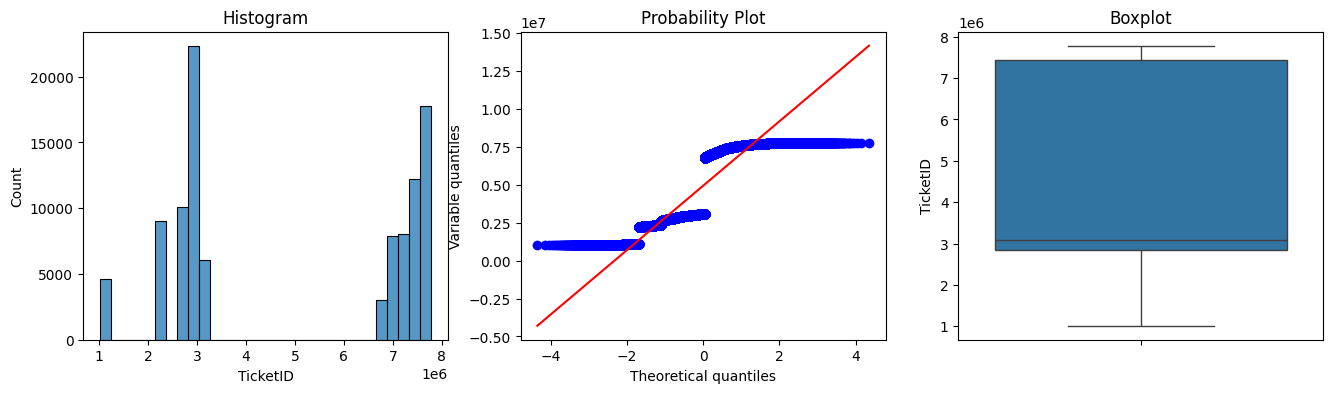

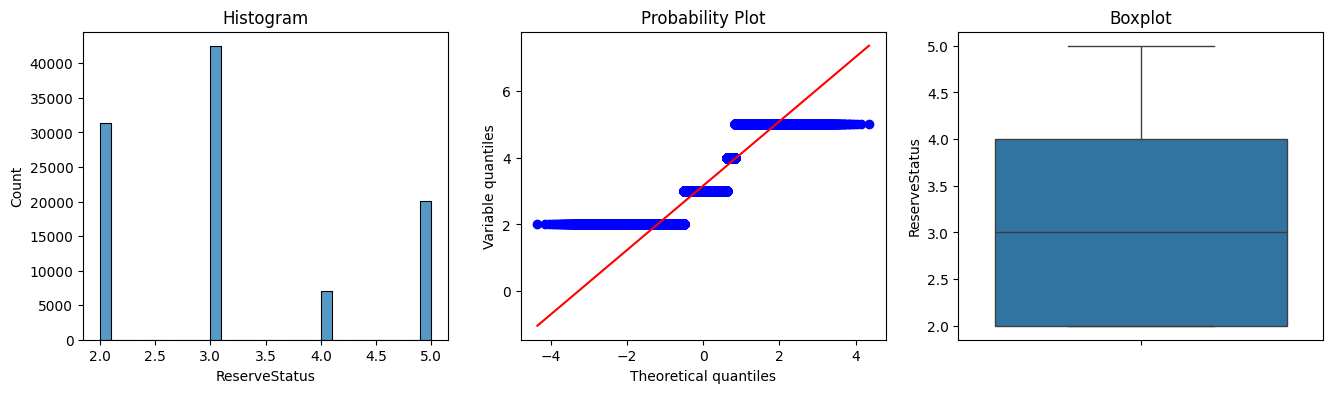

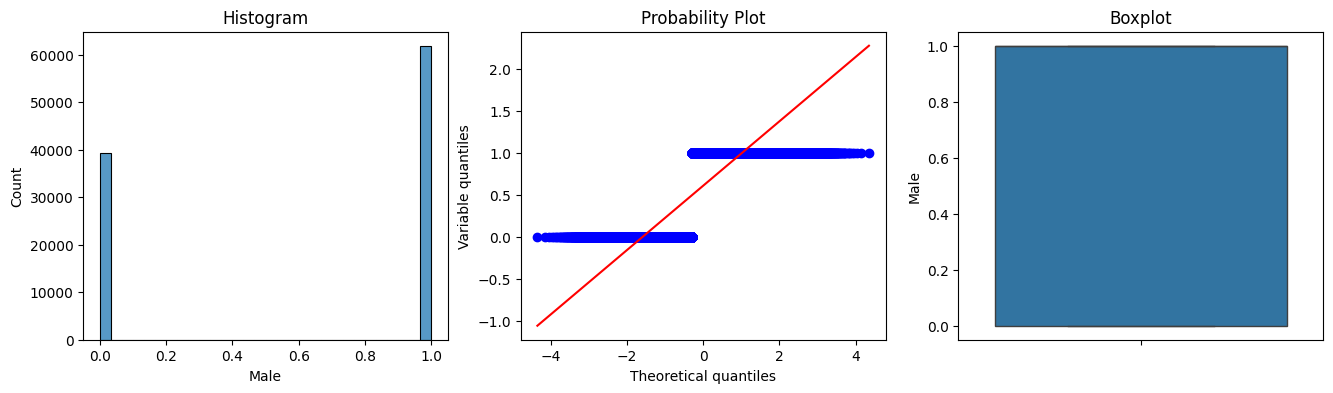

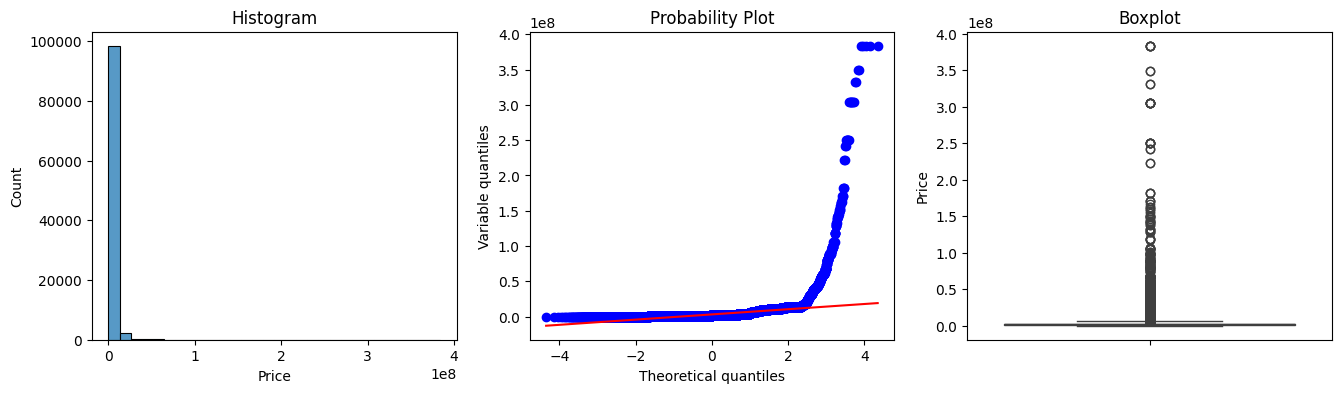

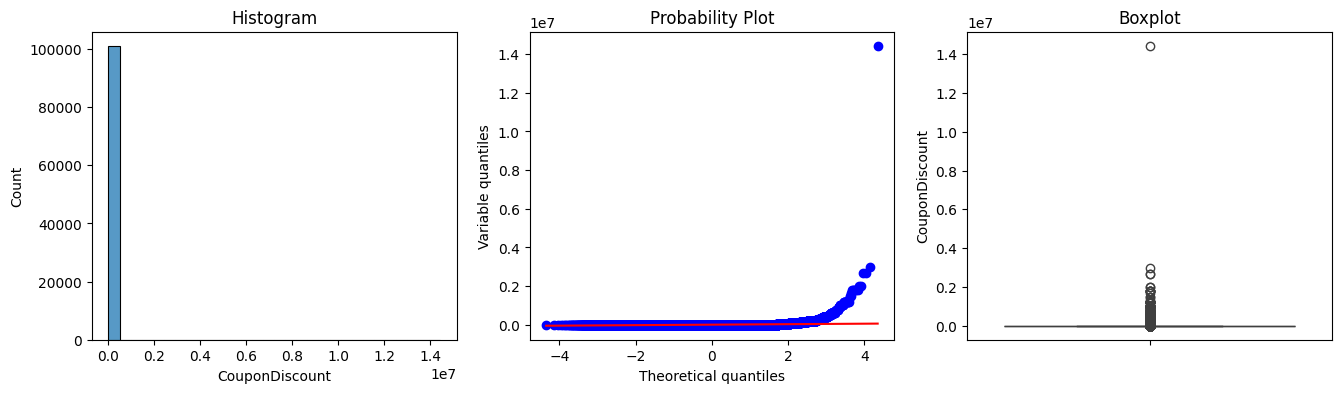

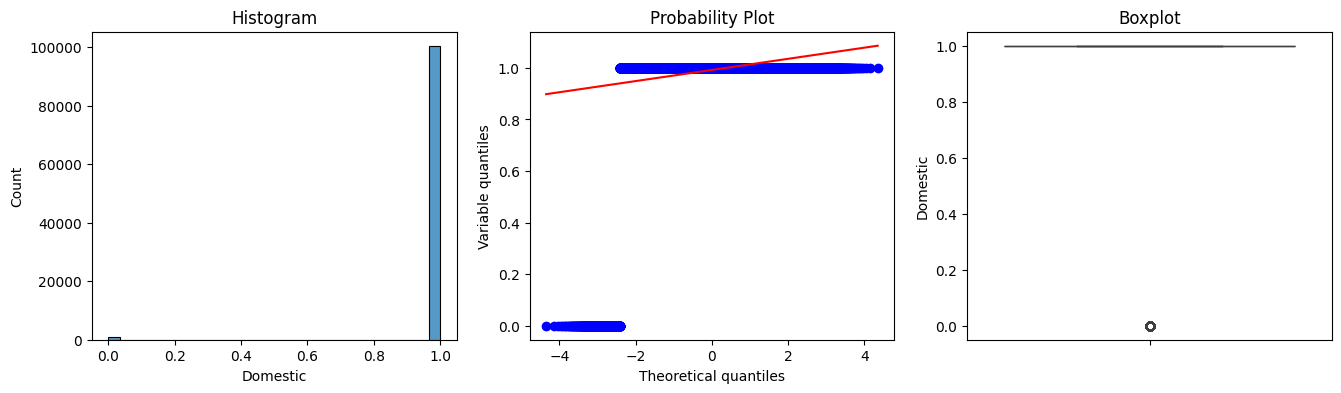

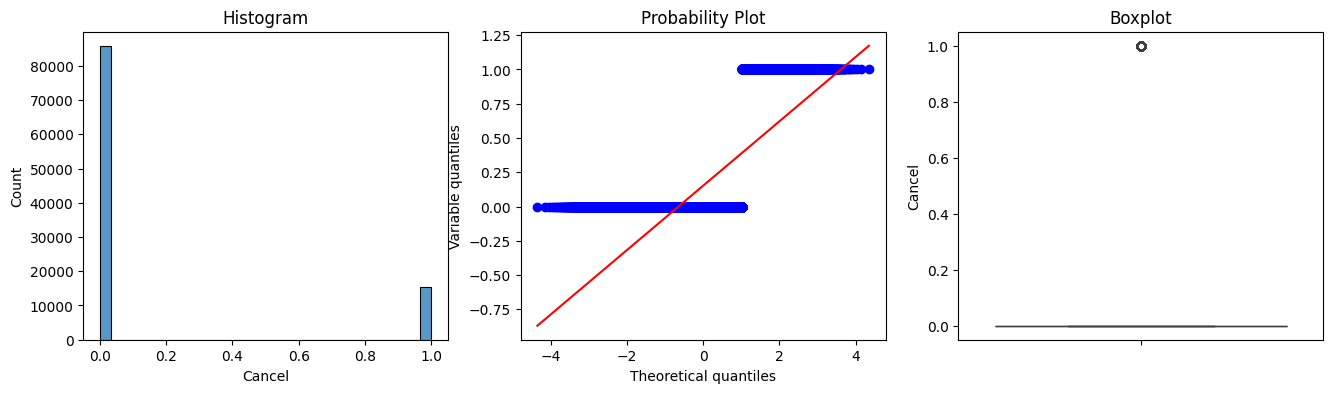

In [8]:
# Terapkan check_plot pada setiap kolom numerik
for col in numeric_cols:
    check_plot(df, col)

In [9]:
def find_outlier_boundary(df, variable):

    # Mari kita hitung batas luar yang merupakan outlier

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * 1.5)
    upper_boundary = df[variable].quantile(0.75) + (IQR * 1.5)

    return upper_boundary, lower_boundary

We only handle outlier in `Price`. for `CouponDiscount`,because not all customer get `CouponDiscount` so the outlier if reasonable.

In [10]:
# Handling outlier
col_outlier = ['Price']
for col in col_outlier:
    upper_limit, lower_limit = find_outlier_boundary(df, col)
    df = df[(df[col] <= upper_limit) & (df[col] >= lower_limit)]

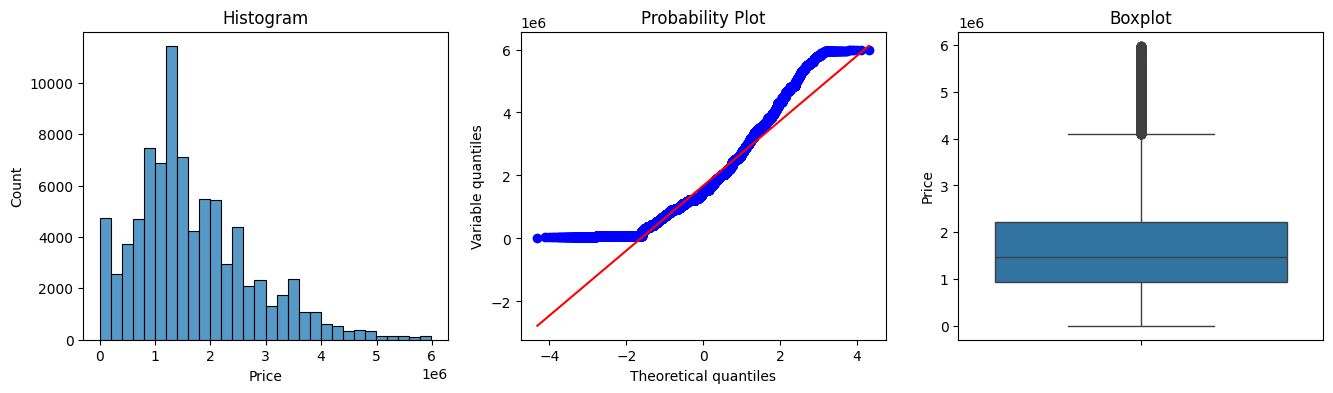

In [11]:
# Terapkan check_plot pada setiap kolom numerik
for col in col_outlier:
    check_plot(df, col)

## Distribution of Gender on Cancellation

<Figure size 1000x600 with 0 Axes>

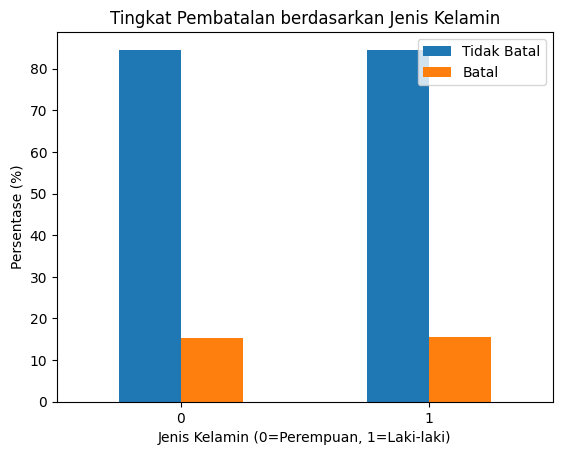

In [12]:
plt.figure(figsize=(10, 6))
gender_cancel = pd.crosstab(df['Male'], df['Cancel'], normalize='index') * 100
gender_cancel.plot(kind='bar')
plt.title('Tingkat Pembatalan berdasarkan Jenis Kelamin')
plt.xlabel('Jenis Kelamin (0=Perempuan, 1=Laki-laki)')
plt.ylabel('Persentase (%)')
plt.legend(['Tidak Batal', 'Batal'])
plt.xticks(rotation=0)
plt.show()

**Insight**: Gender shows no difference in cancellation behavior. Both male and female customers cancel at approximately similar rates, suggesting that gender-specific marketing strategies may not be effective for reducing cancellations.

## The Influence of Travel Reason on Cancellation

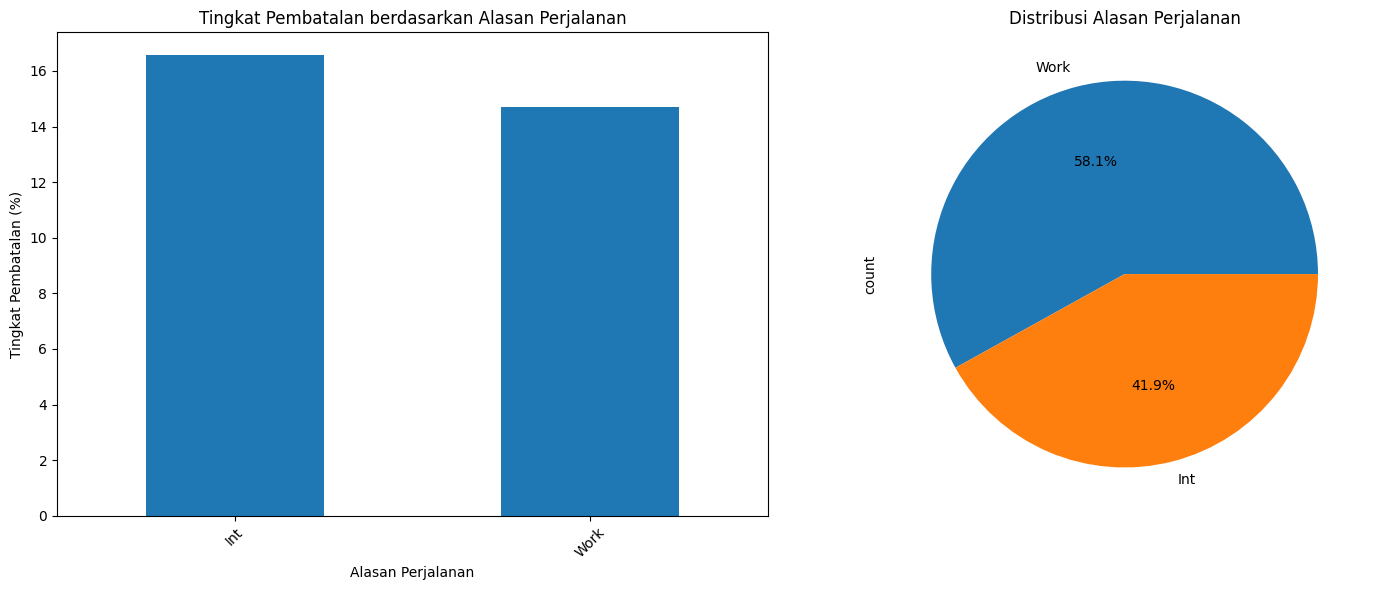

In [13]:
plt.figure(figsize=(15, 6))

# Tingkat pembatalan per alasan perjalanan
plt.subplot(1, 2, 1)
trip_cancel = df.groupby('TripReason')['Cancel'].mean().sort_values(ascending=False) * 100
trip_cancel.plot(kind='bar')
plt.title('Tingkat Pembatalan berdasarkan Alasan Perjalanan')
plt.xlabel('Alasan Perjalanan')
plt.ylabel('Tingkat Pembatalan (%)')
plt.xticks(rotation=45)

# Distribusi alasan perjalanan
plt.subplot(1, 2, 2)
df['TripReason'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribusi Alasan Perjalanan')

plt.tight_layout()
plt.show()

**Insight**: Business travelers(58.1%) show significantly higher distribution compared to leisure travelers(41.9%). but leisure travelers(16%) have higher chance to cancel than business travelers (14%). This indicates that business trips are more scheduled that make it harder to last-minute plan modifications.

## The Price VS Cancallation

Text(0.5, 1.0, 'Distribusi Harga vs Pembatalan')

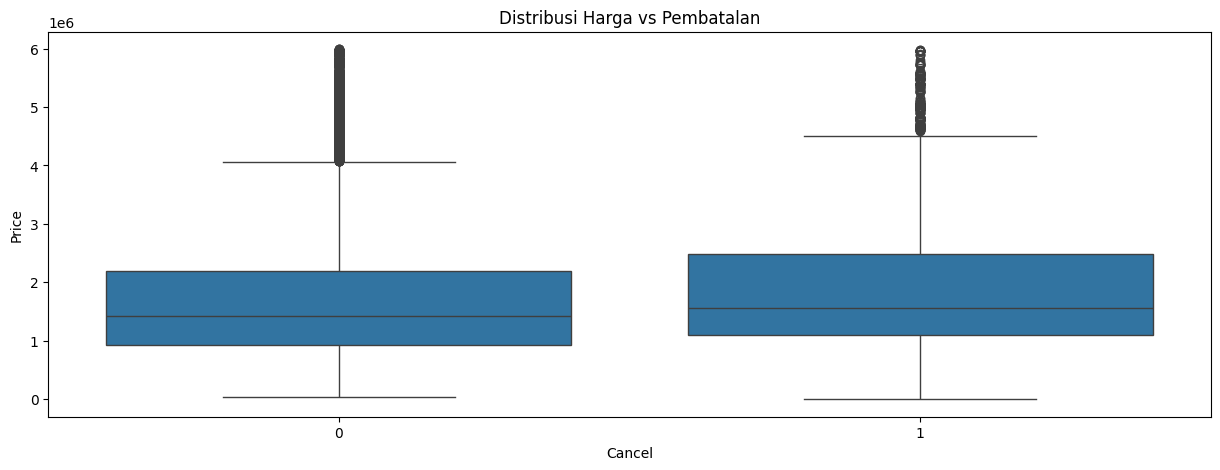

In [14]:
plt.figure(figsize=(15, 5))
sns.boxplot(x='Cancel', y='Price', data=df)
plt.title('Distribusi Harga vs Pembatalan')

**Insight**: Higher-priced tickets tend to have lower cancellation rates. Customers investing more money appear more committed to their travel plans, while cheaper tickets are treated more disposably.

## The Price Group VS Cancellation

/tmp/ipython-input-444653781.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_group_cancel = df.groupby('PriceGroup')['Cancel'].mean().sort_values(ascending=False) * 100


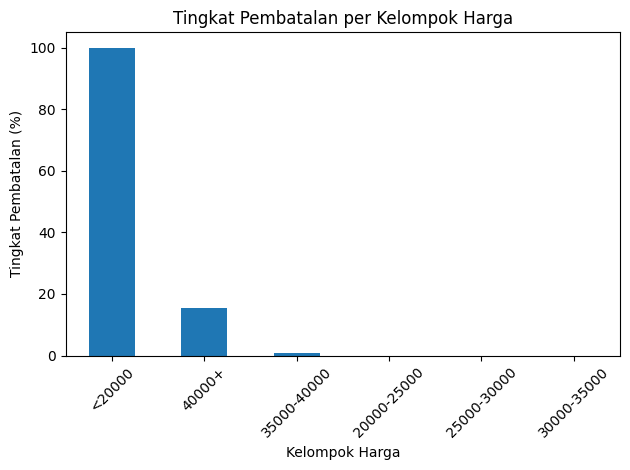

In [15]:
price_group_cancel = df.groupby('PriceGroup')['Cancel'].mean().sort_values(ascending=False) * 100
price_group_cancel.plot(kind='bar')
plt.title('Tingkat Pembatalan per Kelompok Harga')
plt.xlabel('Kelompok Harga')
plt.ylabel('Tingkat Pembatalan (%)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**Insight**: Premium price segments demonstrate the lowest cancellation rates, reinforcing that customers paying premium prices are more serious about their travel commitments.

## The Discount Group VS Cancellation

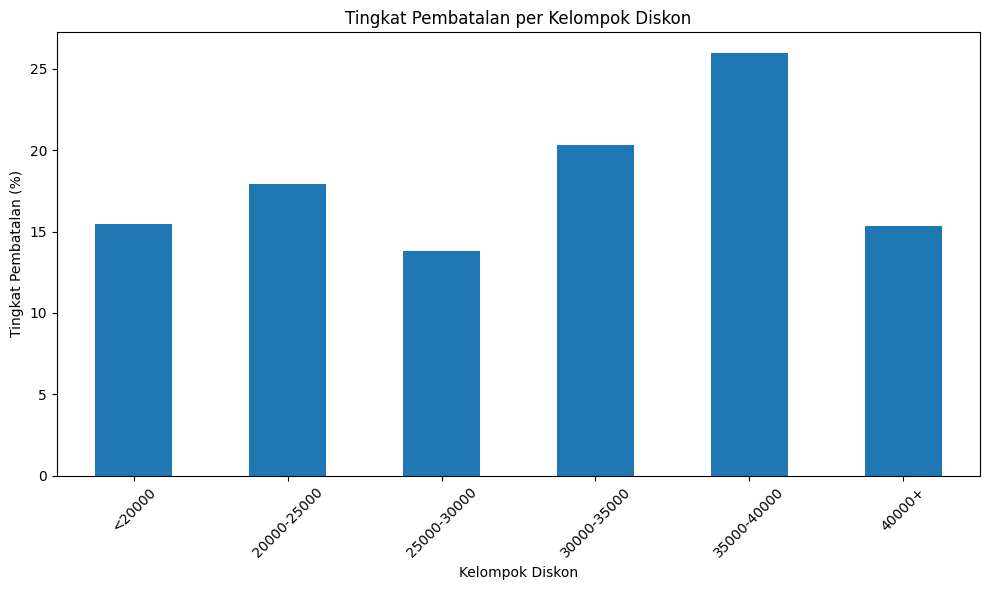

In [30]:
plt.figure(figsize=(10, 6))

# Gunakan categorical sort dengan urutan yang sudah ditentukan
discount_cancel = df.groupby('CouponDiscountGroup', observed=True)['Cancel'].mean().reindex(Discount_order) * 100

# Plot
discount_cancel.plot(kind='bar')
plt.title('Tingkat Pembatalan per Kelompok Diskon')
plt.xlabel('Kelompok Diskon')
plt.ylabel('Tingkat Pembatalan (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Insight**: Discount groups show the most imbalance between group based on cancellation.

## The Lead Time Analysis (Order-Departure Distance)

Text(0.5, 1.0, 'Lead Time vs Pembatalan')

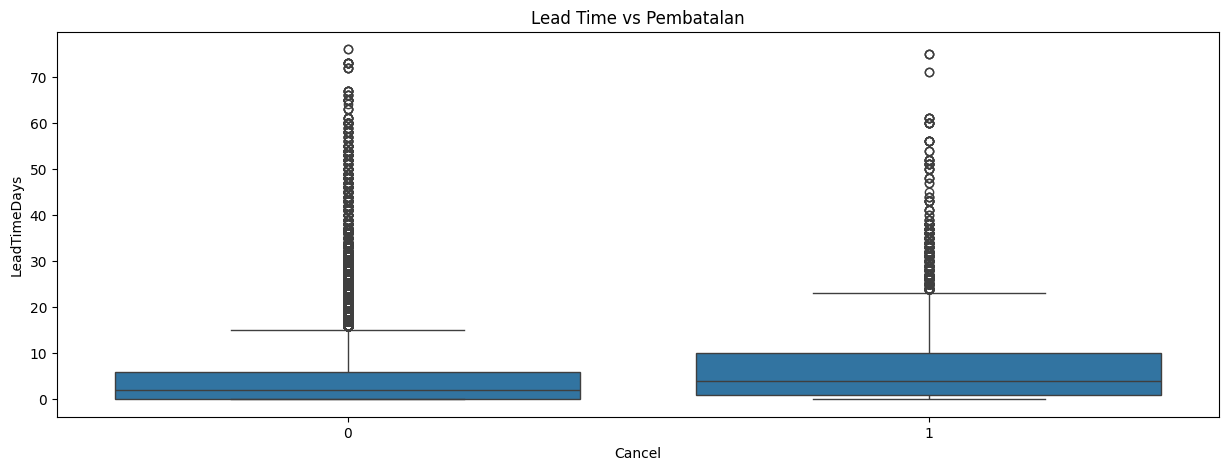

In [17]:
df['LeadTimeDays'] = (df['DepartureTime'] - df['Created']).dt.days

plt.figure(figsize=(15, 5))

sns.boxplot(x='Cancel', y='LeadTimeDays', data=df)
plt.title('Lead Time vs Pembatalan')

**Insight**: Longer lead times correlate strongly with higher cancellation rates. Bookings made far in advance are much more likely to be canceled, suggesting that early planners have more opportunities for plans to change.

## The Cancellation per Day

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

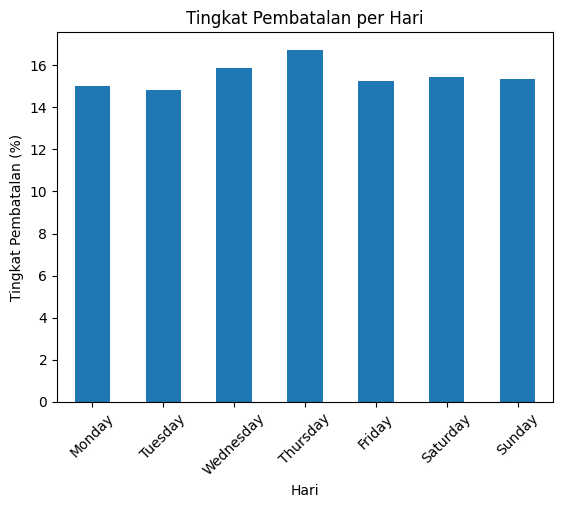

In [18]:
df['DayOfWeek'] = df['DepartureTime'].dt.day_name()

day_cancel = df.groupby('DayOfWeek')['Cancel'].mean() * 100
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_cancel = day_cancel.reindex(day_order)
day_cancel.plot(kind='bar')
plt.title('Tingkat Pembatalan per Hari')
plt.xlabel('Hari')
plt.ylabel('Tingkat Pembatalan (%)')
plt.xticks(rotation=45)

**Insight**: In thursday there are higher cancellation rates on 16% than other days.

## The Cancellation per Month

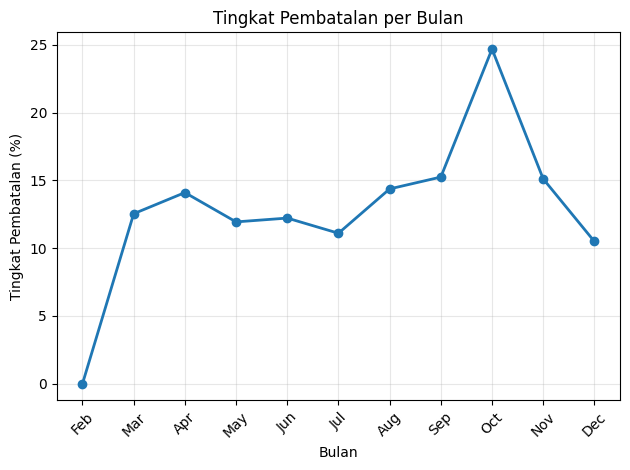

In [19]:
# Buat kolom bulan numerik untuk pengurutan
df['MonthNum'] = df['DepartureTime'].dt.month
month_cancel = df.groupby('MonthNum')['Cancel'].mean().sort_index() * 100

# Definisikan nama bulan untuk label
month_names = ['Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.plot(month_names, month_cancel.values, marker='o', linewidth=2, markersize=6)
plt.title('Tingkat Pembatalan per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Tingkat Pembatalan (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Insight**: Clear seasonal patterns emerge, with october 25% (likely holiday seasons or peak travel periods) showing distinct cancellation behaviors that could inform inventory and pricing strategies.

## The Vehicle Type

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Train'),
  Text(1, 0, 'Bus'),
  Text(2, 0, 'Plane'),
  Text(3, 0, 'InternationalPlane')])

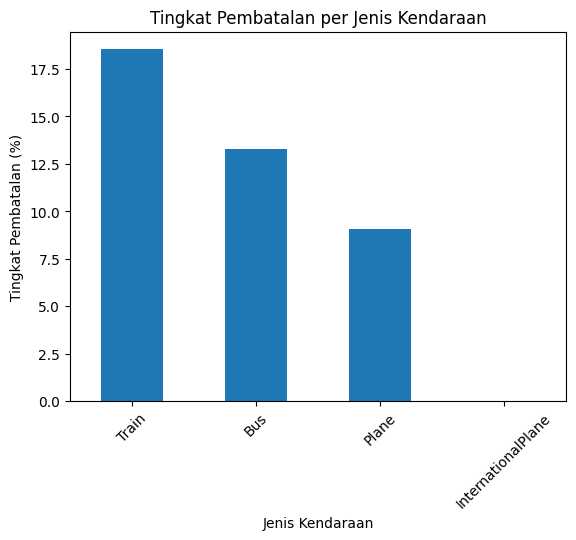

In [20]:
vehicle_cancel = df.groupby('Vehicle')['Cancel'].mean().sort_values(ascending=False) * 100
vehicle_cancel.plot(kind='bar')
plt.title('Tingkat Pembatalan per Jenis Kendaraan')
plt.xlabel('Jenis Kendaraan')
plt.ylabel('Tingkat Pembatalan (%)')
plt.xticks(rotation=45)

**Insight**: Transportation modes using Train have higher cancellation rate more than 17.5% than other transportation such as bus with 12.5% percentage of cancellation rate and plane with less than 10% rate.

## The Top 5 Routes with the Highest Cancellations

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '(بندرعباس, فسا)'),
  Text(1, 0, '(بهاباد, کرمان)'),
  Text(2, 0, '(بهاباد, مشهد)'),
  Text(3, 0, '(بجستان, تهران)'),
  Text(4, 0, '(گرگان, کرمان)')])

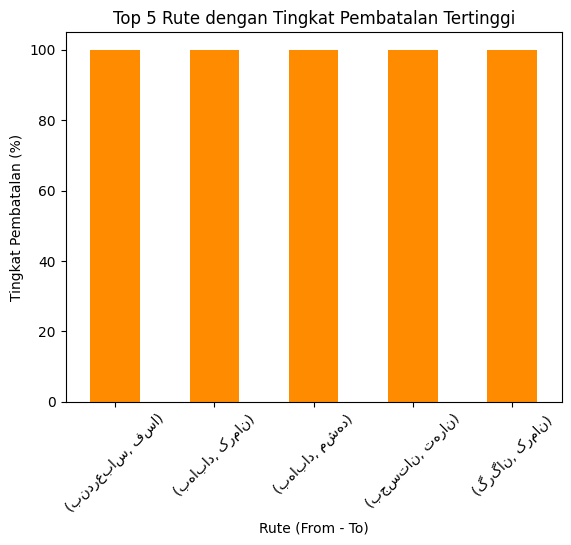

In [21]:
route_cancel = df.groupby(['From', 'To'])['Cancel'].mean().sort_values(ascending=False).head(5) * 100
route_cancel.plot(kind='bar')
plt.title('Top 5 Rute dengan Tingkat Pembatalan Tertinggi')
plt.xlabel('Rute (From - To)')
plt.ylabel('Tingkat Pembatalan (%)')
plt.xticks(rotation=45)

**Insight**: `بندرعباس - فسا`, `بهاباد - کرمان`, `بهاباد - مشهد`, `بجستان - تهران`, `گرگان - کرمان`  (`Bandar Abbas - Fasa`, `Bahabad - Kerman`, `Bahabad - Mashhad`, `Bajistan - Tehran`, `Gorgan - Kerman`) show higher cancellation rates, potentially indicating oversupply, competitive pressure, or route-specific issues that need addressing.

## The Routes Distribution

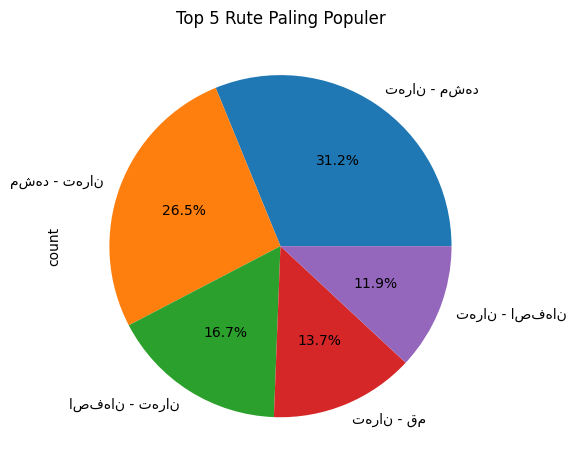

In [29]:
df['Route'] = df['From'] + ' - ' + df['To']
top_routes = df['Route'].value_counts().head(5)
top_routes.plot(kind='pie', autopct='%1.1f%%')
plt.title('Top 5 Rute Paling Populer')

plt.tight_layout()
plt.show()

**Insight**: Routes from `Tehran - Mashad` (31.2%), `Mashad - Tehran` (26.5%), `Isfahan - Tehran` (16.7%), `Tehran - qom` (13.7%), `Tehran - Isfahan` (11.9%)  dominate the booking volume, suggesting that focusing cancellation reduction efforts on these key routes could have disproportionate business impact.

## The Overtime cancellation trend

Text(0, 0.5, 'Tingkat Pembatalan (%)')

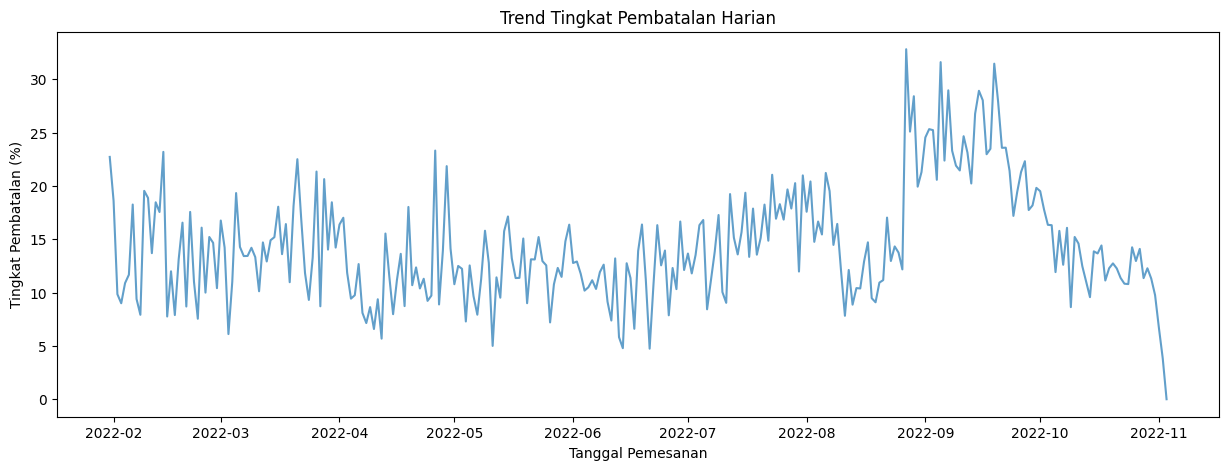

In [23]:
plt.figure(figsize=(15, 5))

df['CreatedDate'] = df['Created'].dt.date
daily_cancel = df.groupby('CreatedDate')['Cancel'].mean() * 100
daily_cancel.plot(kind='line', alpha=0.7)
plt.title('Trend Tingkat Pembatalan Harian')
plt.xlabel('Tanggal Pemesanan')
plt.ylabel('Tingkat Pembatalan (%)')


**Insight**: Cancellation rates show in September to October have a high cancelation rate potentially correlated with promotional periods, seasonal events, or external factors.

## Overall cancellation rate

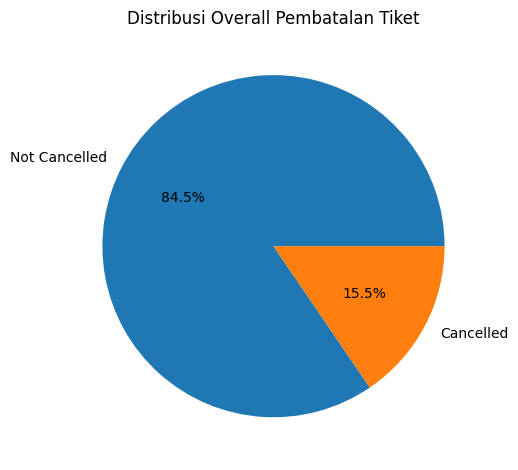


Overall Cancellation Rate: 15.48%


In [24]:
cancel_counts = df['Cancel'].value_counts()
plt.pie(cancel_counts.values, labels=['Not Cancelled', 'Cancelled'], autopct='%1.1f%%')
plt.title('Distribusi Overall Pembatalan Tiket')

plt.tight_layout()
plt.show()

print(f"\nOverall Cancellation Rate: {df['Cancel'].mean()*100:.2f}%")

**Insight**: Overall Cancellation rate is 15.48%

## Practical Recommendations to Reduce Flight Cancellations

**1. Understanding Our Travelers**

**Business vs Leisure Travelers:** Our Leisure travelers tend to cancel more often. This might be because vacation plans change more frequently than business trips. For leisure bookings, we might want to introduce more flexible payment plans or offer cancellation insurance as an add-on. For business travelers, our current approach seems to be working well, so we can maintain those policies.


**2. Pricing & Discount Strategies**

**Ticket Pricing:** Interestingly, cheaper tickets get cancelled more often. It might help to add some extra value to these tickets - maybe include a meal or travel insurance to make customers feel more committed. For our higher-priced tickets that rarely get cancelled, we're in a good position.

**Discount Approach:** Really deep discounts seem to attract people who cancel easily. I think we'd do better with moderate discounts that still give good value but attract more serious customers. The sweet spot appears to be in the middle discount ranges.


**3. Timing Considerations**

**Early Bookings:** When people book way in advance, they're more likely to cancel. We could offer free cancellation for the first 24 hours, then gradually increase cancellation fees as the travel date gets closer. Another option would be to sell cancellation insurance as an add-on.

**Weekly Patterns:** I noticed cancellations tend to spike on certain days (like Wednesday and Thursday). Maybe we could test different approaches on these high-risk days.

**Seasonal Trends:** During months when we typically see more cancellations, we might want to adjust our inventory or pricing to account for this pattern.


**4. Route-Specific Insights**

**Domestic vs International:** Domestic flights get cancelled more often, because i notice there is no international flight in this company.

**Problem Routes:** For routes with consistently high cancellation rates, it might be worth investigating why. Are customers booking multiple options and then choosing one? For these specific routes, we could consider non-refundable deposits.


**5. Overall Approach**

**Daily Monitoring:** Keeping an eye on daily cancellation patterns could help us spot issues early. If we see cancellations rising on a particular day, we could quickly offer promotions to fill those seats.
Loyalty Benefits: A good loyalty program might help keep customers committed to their bookings.

**Flexible Fees:** Rather than one-size-fits-all cancellation fees, we could adjust them based on how likely a booking is to be cancelled (considering how far in advance it was booked, the route, season, etc.).
These are just some thoughts based on what the data is showing us. The key seems to be finding the right balance between being flexible for genuine changes while discouraging casual cancellations.